# Multi-Armed Bandits and Reinforcement Learning with Amazon SageMaker

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [AWS Reinforcement Learning Container](https://github.com/aws/sagemaker-rl-container) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

![](img/multi_armed_bandit_maximize_reward.png)

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

# Relevant Links

In-Practice
* [AWS Blog Post on Contextual Multi-Armed Bandits](https://aws.amazon.com/blogs/machine-learning/power-contextual-bandits-using-continual-learning-with-amazon-sagemaker-rl/)
* [Multi-Armed Bandits at StitchFix](https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/)
* [Introduction to Contextual Bandits](https://getstream.io/blog/introduction-contextual-bandits/)
* [Vowpal Wabbit Contextual Bandit Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms)

Theory
* [Learning to Interact](https://hunch.net/~jl/interact.pdf)
* [Contextual Bandit Bake-Off](https://arxiv.org/pdf/1802.04064.pdf)
* [Doubly-Robust Policy Evaluation and Learning](https://arxiv.org/pdf/1103.4601.pdf)

Code
* [AWS Open Source Reinforcement Learning Containers](https://github.com/aws/sagemaker-rl-container)
* [AWS Open Source Bandit Experiment Manager](./common/sagemaker_rl/orchestrator/workflow/manager)
* [Vowpal Wabbit Reinforcement Learning Framework](https://github.com/VowpalWabbit/)

# AWS Open Source Bandit `ExperimentManager` Library

![](img/multi_armed_bandit_traffic_shift.png)

The bandit model is implemented by the open source [**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) provided with this example.  This This implementation continuously updates a Vowpal Wabbit reinforcement learning model using Amazon SageMaker, DynamoDB, Kinesis, and S3.

The client application, a recommender system with a review service in our case, pings the SageMaker hosting endpoint that is serving the bandit model.  The application sends the an `event` with the `context` (ie. user, product, and review text) to the bandit model and receives a recommended action from the bandit model.  In our case, the action is 1 of 2 BERT models that we are testing.  The bandit model stores this event data (given context and recommended action) in S3 using Amazon Kinesis.  _Note:  The context makes this a "contextual bandit" and differentiates this implementation from a regular multi-armed bandit._

The client application uses the recommended BERT model to classify the review text as star rating 1 through 5 and  compares the predicted star rating to the user-selected star rating.  If the BERT model correctly predicts the star rating of the review text (ie. matches the user-selected star rating), then the bandit model is rewarded with `reward=1`.  If the BERT model incorrectly classifies the star rating of the review text, the bandit model is not rewarded (`reward=0`).

The client application stores the rewards data in S3 using Amazon Kinesis.  Periodically (ie. every 100 rewards), we incrementally train an updated bandit model with the latest the reward and event data.  This updated bandit model is evaluated against the current model using a holdout dataset of rewards and events.  If the bandit model accuracy is above a given threshold relative to the existing model, it is automatically deployed in a blue/green manner with no downtime.  SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA).  By default, we apply [**doubly robust (DR) estimation**](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit model tries to minimize the cost (`1 - reward`), so a smaller evaluation score indicates better bandit model performance.

Unlike traditional A/B tests, the bandit model will learn the best BERT model (action) for a given context over time and begin to shift traffic to the best model.  Depending on the aggressiveness of the bandit model algorithm selected, the bandit model will continuously explore the under-performing models, but start to favor and exploit the over-performing models.  And unlike A/B tests, multi-armed bandits allow you to add a new action (ie. BERT model) dynamically throughout the life of the experiment.  When the bandit model sees the new BERT model, it will start sending traffic and exploring the accuracy of the new BERT model - alongside the existing BERT models in the experiment.

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of the SageMaker training and hosting cluster instances.  The workflow remains the same in `local_mode`, but runs much faster for small datasets.  Hence, it is a useful tool for experimenting and debugging.  However, it will not scale to production use cases with high throughput and large datasets.  In `local_mode`, the training, evaluation, and hosting is done in the local [SageMaker Vowpal Wabbit Docker Container](https://github.com/aws/sagemaker-rl-container).

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
import yaml
import sys
import numpy as np
import time
import sagemaker

sys.path.append('common')
sys.path.append('common/sagemaker_rl')

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `s3://sagemaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

The Docker image is defined here:  https://github.com/aws/sagemaker-rl-container/blob/master/vw/docker/8.7.0/Dockerfile

In [3]:
!pygmentize 'config.yaml'

resource:
  shared_resource:
    resources_cf_stack_name: "BanditsSharedResourceStack" # cloud formation stack
    experiment_db:
      table_name: "BanditsExperimentTable" # Dynamo table for status of an experiment
    model_db:
      table_name: "BanditsModelTable" # Dynamo table for status of all models trained
    join_db:
      table_name: "BanditsJoinTable" # Dynamo table for status of all joining job for reward ingestion
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu" # Vowpal Wabbit container
algor: # Vowpal Wabbit algorithm parameters
  algorithms_parameters:
    exploration_policy: "cover" # supports "egreedy", "bag", "cover"
    epsilon: 0.10 # percent to explore with e

In [4]:
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

# Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [5]:
# from markdown_helper import *
# from IPython.display import Markdown

# display(Markdown(generate_help_for_experiment_manager_permissions(role)))

### Client Application (Environment)
The client application simulates a live environment that uses the bandit model to recommend a BERT model to classify review text submitted by the application user. 

The logic of reward generation resides in the client application.  We simulate the online learning loop with feedback.  The data consists of 2 actions - 1 for each BERT model under test.  If the bandit model selects the right class, then the model is rewarded with `reward=1`.  Otherwise, the bandit model receives `reward=0`.

The workflow of the client application is as follows:
- Our client application picks sample review text at random, which is sent to the bandit model (SageMaker endpoint) to recommend an action (BERT model) to classify the review text into star rating 1 through 5.
- The bandit model returns an action, an action probability, and an `event_id` for this prediction event.
- Since the client application uses the Amazon Customer Reviews Dataset, we know the true star rating for the review text
- The client application compares the predicted and true star rating and assigns a reward to the bandit model using Amazon Kinesis, S3, and DynamoDB.  (The `event_id` is used to join the event and reward data.)

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action_probability>` with the reward data. 

In a later cell of this notebook, we illustrate how the client application interacts with the bandit model endpoint and receives the recommended action (BERT model).

### Step-by-step bandits model development

[**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [6]:
import time
timestamp = int(time.time())

experiment_name = 'bandits-{}'.format(timestamp)

# `ExperimentManager` will create a AWS CloudFormation Stack of additional resources needed for the Bandit experiment. 

In [7]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Creating a new CloudFormation stack for Shared Resources. You can always reuse this StackName in your other experiments
INFO:orchestrator.resource_manager:[
    {
        "ParameterKey": "IAMRoleName",
        "ParameterValue": "BanditsIAMRole",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbName",
        "ParameterValue": "BanditsExperimentTable",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbRCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbWCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ModelDbName",
        "ParameterValue": "BanditsModelTable",
        "UsePreviousValue": true,
        "ResolvedValue": "strin

In [8]:
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1598138764'...


In [9]:
bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


# Initialize the Bandit Model
To start a new experiment, we need to initialize the first bandit model or "policy" in reinforcement learning terminology.  

If we have historical data in the format `(state, action, action probability, reward)`, we can perform a "warm start" and learn the bandit model offline.  

However, let's assume we are starting with no historical data and initialize a random bandit model using `initialize_first_model()`.

In [10]:
bandit_experiment_manager.initialize_first_model()

INFO:orchestrator:Next Model name would be bandits-1598138764-model-id-1598138814
INFO:orchestrator:Start training job for model 'bandits-1598138764-model-id-1598138814''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpc14xu1sb_algo-1-aocdw_1 ... 
Attaching to tmpc14xu1sb_algo-1-aocdw_12mdone
algo-1-aocdw_1  | 2020-08-22 23:27:21,223 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aocdw_1  | 2020-08-22 23:27:21,235 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aocdw_1  | 2020-08-22 23:27:21,247 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aocdw_1  | 2020-08-22 23:27:21,256 sagemaker-containers INFO     Invoking user script
algo-1-aocdw_1  | 
algo-1-aocdw_1  | Training Env:
algo-1-aocdw_1  | 
algo-1-aocdw_1  | {
algo-1-aocdw_1  |     "additional_framework_parameters": {
algo-1-aocdw_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-aocdw_1  |     },
algo-1-aocdw_1  |     "channel_input_dirs": {},
algo-1-aocdw_1  |     "current_host": "algo-1-aocdw",
algo-1-aocdw_1  |     "framework_module": null,
algo-1-aocdw_1  |     "hosts": [
algo-1-aocdw_1  |         "algo-1-aocdw"
al

Aborting on container exit...
===== Job Complete =====


# ^^ Ignore `Failed to delete: /tmp/...` message above.  This is OK. ^^

# Check Experiment State:  TRAINED
`training_state`: `TRAINED`

Remember the `last_trained_model_id`.

In [11]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598138764',
 'training_workflow_metadata': {'last_trained_model_id': 'bandits-1598138764-model-id-1598138814',
  'next_model_to_train_id': None,
  'training_state': <TrainingState.TRAINED: 'TRAINED'>},
 'hosting_workflow_metadata': {'last_hosted_model_id': None,
  'hosting_endpoint': None,
  'hosting_state': None,
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Deploy the Bandit Model

Once training and evaluation is done, we can deploy the model.

In [12]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name

!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [13]:
# Check the model_id of the last model trained.
print('Deploying newly-trained bandit model: {}'.format(bandit_experiment_manager.last_trained_model_id))

Deploying newly-trained bandit model: bandits-1598138764-model-id-1598138814


In [14]:
print('Deploying bandit model_id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id) 

Deploying bandit model_id bandits-1598138764-model-id-1598138814


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598138814' is ready to deploy.


Attaching to tmpbblhsg93_algo-1-o4bln_1
algo-1-o4bln_1  | 17:C 22 Aug 2020 23:27:37.702 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
algo-1-o4bln_1  | 17:C 22 Aug 2020 23:27:37.702 # Redis version=5.0.6, bits=64, commit=00000000, modified=0, pid=17, just started
algo-1-o4bln_1  | 17:C 22 Aug 2020 23:27:37.702 # Configuration loaded
algo-1-o4bln_1  | 17:M 22 Aug 2020 23:27:37.703 # You requested maxclients of 10000 requiring at least 10032 max file descriptors.
algo-1-o4bln_1  | 17:M 22 Aug 2020 23:27:37.703 # Server can't set maximum open files to 10032 because of OS error: Operation not permitted.
algo-1-o4bln_1  | 17:M 22 Aug 2020 23:27:37.703 # Current maximum open files is 4096. maxclients has been reduced to 4064 to compensate for low ulimit. If you need higher maxclients increase 'ulimit -n'.
algo-1-o4bln_1  | 17:M 22 Aug 2020 23:27:37.703 # WARNING: The TCP backlog setting of 511 cannot be enforced because /proc/sys/net/core/somaxconn is set to the lower value of 128.
algo-1-

# Check Experiment State
`hosting_state`: `DEPLOYED`

The `last_trained_model_id` and `last_hosted_model_id` are now the same as we just deployed the bandit model.

In [15]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598138764',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598138764-model-id-1598138814',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1598138764-model-id-1598138814',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Configure the 2 BERT Models to Test with our Bandit Experiment

Now that the last trained bandit model is deployed as a SageMaker Endpoint, the client application will send the context to the endpoint and receive the recommended action.  The bandit model will recommend 1 of 2 actions in our example:  `1` or `2` which correspond to BERT model 1 and BERT model 2, respectively.  Let's configure these 2 BERT models below.

In [16]:
%store -r tensorflow_endpoint_name

In [17]:
model_1_endpoint_name = tensorflow_endpoint_name

In [18]:
print(model_1_endpoint_name)

tensorflow-training-2020-08-22-20-22-09-110-tf-1598135526


In [19]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_1_endpoint_name)

In [20]:
import json
from sagemaker.tensorflow.serving import Predictor

model1 = Predictor(endpoint_name=model_1_endpoint_name,
                   sagemaker_session=sess,
                   content_type='application/json',
                   model_name='saved_model',
                   model_version=0)

In [21]:
reviews = ['This is great!']

model1_predicted_classes = model1.predict(reviews)

for predicted_class, review in zip(model1_predicted_classes, reviews):
    print('[Predicted Star Rating: {}]'.format(predicted_class), review)

[Predicted Star Rating: 5] This is great!


In [22]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [23]:
%store -r pytorch_endpoint_name

In [24]:
model_2_endpoint_name = pytorch_endpoint_name

In [25]:
print(model_2_endpoint_name)

tensorflow-training-2020-08-22-20-22-09-110-pt-1598136243


In [26]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_2_endpoint_name)

In [27]:
import json
from sagemaker.predictor import RealTimePredictor

model2 = RealTimePredictor(endpoint=model_2_endpoint_name,
                           sagemaker_session=sess)

In [28]:
reviews = 'This is great!'

model2_predicted_class = model2.predict(reviews).decode('utf-8')

print(model2_predicted_class)

5


In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Initialize the Client Application

In [30]:
import csv
import numpy as np

class ClientApp():
    def __init__(self, data, num_events, bandit_model, bert_model_map):
        self.bandit_model = bandit_model
        self.bert_model_map = bert_model_map
        
        self.num_actions = 2

        df_reviews = pd.read_csv(data, 
                                 delimiter='\t', 
                                 quoting=csv.QUOTE_NONE,
                                 compression='gzip')
        df_scrubbed = df_reviews[['review_body', 'star_rating']].sample(n=num_events) # .query('star_rating == 1')
        df_scrubbed = df_scrubbed.reset_index()
        df_scrubbed.shape
        np_reviews = df_scrubbed.to_numpy()

        np_reviews = np.delete(np_reviews, 0, 1)
        
        # Last column is the label, the rest are the features (contexts)
        self.labels = np_reviews[:, -1]
        self.contexts = np_reviews[:, :-1].tolist()

        self.optimal_rewards = [1]
        self.rewards_buffer = []
        self.joined_data_buffer = []

    def choose_random_context(self):
#        context_index = np.random.choice(self.contexts.shape[0])
        context_index = np.random.choice(len(self.contexts))
        context = self.contexts[context_index]
        return context_index, context    

    def clear_buffer(self):
        self.rewards_buffer.clear()
        self.joined_data_buffer.clear()  

    def get_reward(self, 
                   context_index, 
                   action, 
                   event_id, 
                   bandit_model_id, 
                   action_prob, 
                   sample_prob, 
                   local_mode):

        context_to_predict = self.contexts[context_index][0]
#        print('Context to predict{}'.format(context_to_predict))
        print('Context index {}'.format(context_index))
    
        label = self.labels[context_index]
        print('Label {}'.format(label))
        
        print('Action {}'.format(action))
        
        bert_model = self.bert_model_map[action]
        try: 
            # TensorFlow takes a list and returns str
            bert_predicted_class = bert_model.predict([context_to_predict])[0]
            bert_predicted_class #.decode('utf-8')
            print('Predicted Class from Model 1 {}'.format(bert_predicted_class))        
        except:
            # PyTorch takes a single review and returns bytes
            #context = context_index            
            bert_predicted_class = bert_model.predict(context_to_predict)[0]
            bert_predicted_class = bert_predicted_class #.decode('utf-8')
            print('Predicted Class from Model 2 {}'.format(bert_predicted_class))
        
        # Calculate difference between predicted and actual label
        if abs(int(bert_predicted_class) - int(label)) <= 1:
            reward = 1
        else:
            reward = 0

        if local_mode:
            json_blob = {"reward": reward,
                         "event_id": event_id,
                         "action": action,
                         "action_prob": action_prob,
                         "model_id": bandit_model_id,
                         "observation": [context_index],
                         "sample_prob": sample_prob}
            
            self.joined_data_buffer.append(json_blob)
        else:
            json_blob = {"reward": reward, "event_id": event_id}
            self.rewards_buffer.append(json_blob)
        
        return reward
    

In [31]:
bandit_model = bandit_experiment_manager.predictor

client_app = ClientApp(data='./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz',
                       num_events=100,
                       bandit_model=bandit_model,
                       bert_model_map={
                         1: model1,
                         2: model2
                       })

Make sure that `num_arms` specified in `config.yaml` is equal to the total unique actions in the simulation application.

In [32]:
print('Testing {} BERT models'.format(client_app.num_actions))

assert client_app.num_actions == bandit_experiment_manager.config["algor"]["algorithms_parameters"]["num_arms"]

Testing 2 BERT models


In [33]:
import time

context_index, context = client_app.choose_random_context()
action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

print('event ID: {}\nbert_model_id: {}\naction_probability: {}'.format(event_id, action, action_prob, bandit_model_id))

event ID: 30167467450036928094876434810243514370
bert_model_id: 1
action_probability: 1.0


# Generate Sample Events to Test the Bandit `ExperimentManager`
Thsi will generated sample contexts to pass as events to the bandit using the Amazon Customer Reviews Dataset.  The bandit model will recommend an action (BERT model) based on the context and current state of the bandit.  We will assign a reward using the star ratings from Amazon Customer Reviews Dataset.

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, state, action, action probability>` to S3 using [**Kinesis Firehose**](https://aws.amazon.com/kinesis/data-firehose/). The `ExperimentManager` joins the reward with state, action and action probability using [**Amazon Athena**](https://aws.amazon.com/athena/). 

In [34]:
local_mode = bandit_experiment_manager.local_mode

num_events = 100 

print('Generating {} sample events...'.format(num_events))

for i in range(num_events):
    context_index, context = client_app.choose_random_context()
#    print('Context to predict = {}'.format(context))
#    print('Context observation = [{}]'.format(context_index))    
    action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

    reward = client_app.get_reward(context_index=context_index, 
                                   action=action, 
                                   event_id=event_id, 
                                   bandit_model_id=bandit_model_id, 
                                   action_prob=action_prob, 
                                   sample_prob=sample_prob, 
                                   local_mode=local_mode)    

Generating 100 sample events...
Context index 33
Label 1
Action 1
Predicted Class from Model 1 2
Context index 61
Label 4
Action 1
Predicted Class from Model 1 2
Context index 99
Label 1
Action 1
Predicted Class from Model 1 2
Context index 36
Label 2
Action 1
Predicted Class from Model 1 2
Context index 79
Label 4
Action 1
Predicted Class from Model 1 2
Context index 7
Label 5
Action 1
Predicted Class from Model 1 5
Context index 67
Label 4
Action 1
Predicted Class from Model 1 2
Context index 37
Label 5
Action 1
Predicted Class from Model 1 4
Context index 45
Label 4
Action 1
Predicted Class from Model 1 4
Context index 34
Label 4
Action 1
Predicted Class from Model 1 5
Context index 58
Label 5
Action 1
Predicted Class from Model 1 4
Context index 97
Label 1
Action 1
Predicted Class from Model 1 2
Context index 6
Label 1
Action 1
Predicted Class from Model 1 2
Context index 25
Label 5
Action 1
Predicted Class from Model 1 2
Context index 16
Label 1
Action 1
Predicted Class from Model

# Create Bandit Model Training Data

Join `Event` and `Reward` data and upload to S3 in the following format:

```
{
 'reward': -1, # -1 if the model is wrong, +1 if the model is correct
 'event_id': 131181492351609994318271340276526219266, # unique event id
 'action': 1, # suggested action (bert_model_id 1 or 2)
 'action_prob': 0.9995, # probability that the suggested action is correct
 'model_id': 'bandits-1597631299-model-id-1597631304', # unique bandit_model_id
 'observation': [54], # feature (review_id)
 'sample_prob': 0.43410828171830174 
}
```


In [35]:
if local_mode:
    print('Using local mode with memory buffers.')
    print()
    print(client_app.joined_data_buffer)
    bandit_experiment_manager.ingest_joined_data(client_app.joined_data_buffer)
else:
    print("Using production mode with Kinesis Firehose.  Waiting to flush to S3...")
    print()
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_buffer)
    bandit_experiment_manager.join(rewards_s3_prefix)

Using local mode with memory buffers.

[{'reward': 1, 'event_id': 30173384209213493355607920672454606850, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598138764-model-id-1598138814', 'observation': [33], 'sample_prob': 0.18862655719069443}, {'reward': 0, 'event_id': 30299153371233511993034040145536483330, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598138764-model-id-1598138814', 'observation': [61], 'sample_prob': 0.05884568143257285}, {'reward': 1, 'event_id': 30418651624190526608139630614949265410, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598138764-model-id-1598138814', 'observation': [99], 'sample_prob': 0.27477226025720025}, {'reward': 1, 'event_id': 30512680399744080670755596045040877570, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598138764-model-id-1598138814', 'observation': [36], 'sample_prob': 0.32009306608308064}, {'reward': 0, 'event_id': 30769131662141627477182010651564965890, 'action': 1, 'action_prob': 1.0, 'model_id': 'band

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138883
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138883/train/local-joined-data-1598138884.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138883/eval/local-joined-data-1598138884.csv


# Check Experiment Status:  Joined
`joining_state`:  `SUCCEEDED`

In [36]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598138764',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598138764-model-id-1598138814',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1598138764-model-id-1598138814',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1598138764-join-job-id-1598138883',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Review Bandit Model Training Data

In [37]:
print('Bandit model training data {}'.format(bandit_experiment_manager.last_joined_job_train_data))

Bandit model training data s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138883/train


In [38]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data_s3_uri = S3Downloader.list(bandit_experiment_manager.last_joined_job_train_data)[0]
print(bandit_model_train_data_s3_uri)

s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138883/train/local-joined-data-1598138884.csv


In [39]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data = S3Downloader.read_file(bandit_model_train_data_s3_uri)
print(bandit_model_train_data)

"reward","event_id","action","action_prob","model_id","observation","sample_prob"
"1","30173384209213493355607920672454606850","1","1.0","bandits-1598138764-model-id-1598138814","[33]","0.18862655719069443"
"0","30299153371233511993034040145536483330","1","1.0","bandits-1598138764-model-id-1598138814","[61]","0.05884568143257285"
"1","30418651624190526608139630614949265410","1","1.0","bandits-1598138764-model-id-1598138814","[99]","0.27477226025720025"
"1","30512680399744080670755596045040877570","1","1.0","bandits-1598138764-model-id-1598138814","[36]","0.32009306608308064"
"0","30769131662141627477182010651564965890","1","1.0","bandits-1598138764-model-id-1598138814","[79]","0.4050860969900282"
"1","30939586300101316339330527730823462914","1","1.0","bandits-1598138764-model-id-1598138814","[7]","0.7551264603894219"
"1","31176577541222109543480953189518409730","1","1.0","bandits-1598138764-model-id-1598138814","[37]","0.6982297330820137"
"1","31286093045702326847726020003936468994","1

# Train the Bandit Model

Now we can train a new model with newly collected experiences, and host the resulting model.

In [40]:
print('Trained bandit model id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.train_next_model(input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

Trained bandit model id bandits-1598138764-model-id-1598138814


INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598138814 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598138892''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpe0etoai__algo-1-4juj6_1 ... 
Attaching to tmpe0etoai__algo-1-4juj6_12mdone
algo-1-4juj6_1  | 2020-08-22 23:28:17,422 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4juj6_1  | 2020-08-22 23:28:17,434 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4juj6_1  | 2020-08-22 23:28:17,445 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4juj6_1  | 2020-08-22 23:28:17,454 sagemaker-containers INFO     Invoking user script
algo-1-4juj6_1  | 
algo-1-4juj6_1  | Training Env:
algo-1-4juj6_1  | 
algo-1-4juj6_1  | {
algo-1-4juj6_1  |     "additional_framework_parameters": {
algo-1-4juj6_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-4juj6_1  |     },
algo-1-4juj6_1  |     "channel_input_dirs": {
algo-1-4juj6_1  |         "training": "/opt/ml/input/data/training",
algo-1-4juj6_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-4juj6_1  |     },
al

tmpe0etoai__algo-1-4juj6_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


# Ignore ^^ `Failed to delete` Error Above ^^ 

# Deploy the Bandit Model

In [41]:
print('Deploying bandit model id {}'.format(bandit_experiment_manager.last_hosted_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)

Deploying bandit model id bandits-1598138764-model-id-1598138814


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598138892' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:28:28 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598138814 with Model ID: bandits-1598138764-model-id-1598138892
algo-1-o4bln_1  | [2020-08-22 23:28:28 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:28:28 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:28:28 +0000] [38] [INFO] Booting worker with pid: 38
algo-1-o4bln_1  | [2020-08-22 23:28:28 +0000] [39] [INFO] Booting worker with pid: 39
algo-1-o4bln_1  | [08/22/2020 23:28:28 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:28:28 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:28:28 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/6KY4rciU/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:28:28 INFO 140521295894272] Loaded weights successfully

# Continuously Train, Evaluate, and Deploy a New Bandit Model

#### Train a New Bandit Model
The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training loop in a single cell below.

#### Evaluate New Bandit Model Against Current Bandit Model Before Deploying
After every training cycle, we evaluate if the newly trained model (`last_trained_model_id`) would perform better than the one currently deployed (`last_hosted_model_id`) using a holdout evaluation dataset.  

Details of the join, train, and evaluation steps are tracked in the `BanditsJoinTable` and `BanditsModelTable` DynamoDB tables.  When you have multiple experiments, you can compare them in the `BanditsExperimentTable` DynamoDB table.

#### Deploy the New Bandit Model
If the new bandit model is better than the current bandit model (based on offline evaluation), then we will automatically deploy the new bandit model using a blue-green deployment to avoid downtime. 

#### Monitor the Bandit Model in CloudWatch

In [42]:
from markdown_helper import *
from IPython.display import Markdown

display(Markdown(bandit_experiment_manager.get_cloudwatch_dashboard_details()))

You can monitor your Training/Hosting evaluation metrics on this [CloudWatch Dashboard](https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#dashboards:name=bandits-1598138764;start=PT1H)

(Note: This would need Trained/Hosted Models to be evaluated in order to publish Evaluation Scores)

In [43]:
start_time = time.time()
do_evaluation = True
total_loops = 10 # Increase for higher accuracy
retrain_batch_size = 100 # Model will be trained after every `batch_size` number of data instances
rewards_list = []
event_list = []

local_mode = bandit_experiment_manager.local_mode
for loop_no in range(total_loops):
    print(f"""
    #############
    #### Loop {loop_no+1}
    #############
    """)
    
    # Generate experiences and log them
    for i in range(retrain_batch_size):
        context_index, context = client_app.choose_random_context()
        action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

        print('*** Event ID {} ***'.format(event_id))
        print('Context {}'.format(context_index))    
        print('Recommended Action (BERT model) {}'.format(action))
        print('Action Success Probability {}'.format(action_prob))
        print('Action Sample Probability {}'.format(sample_prob))

        reward = client_app.get_reward(context_index=context_index, 
                                       action=action, 
                                       event_id=event_id, 
                                       bandit_model_id=bandit_model_id, 
                                       action_prob=action_prob, 
                                       sample_prob=sample_prob, 
                                       local_mode=local_mode)

        rewards_list.append(reward)  
        
    # Publish rewards sum for this batch to CloudWatch for monitoring 
    bandit_experiment_manager.cw_logger.publish_rewards_for_simulation(
        bandit_experiment_manager.experiment_id,
        sum(rewards_list[-retrain_batch_size:])/retrain_batch_size
    )
    
    # Join the events and rewards data to use for the next bandit-model training job
    # Use 90% as the training dataset and 10% as the the holdout evaluation dataset
    if local_mode:        
        bandit_experiment_manager.ingest_joined_data(client_app.joined_data_buffer,
                                                     ratio=0.90)
    else:
        # Kinesis Firehose => S3 => Athena
        print("Waiting for firehose to flush data to s3...")
        time.sleep(60) 
        rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_buffer)
        bandit_experiment_manager.join(rewards_s3_prefix, ratio=0.90)
    
    # Train 
    bandit_experiment_manager.train_next_model(
        input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

    # Evaluate and/or deploy the new bandit model
    if do_evaluation:
        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id)

        eval_score_last_trained_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id,
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)

        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id)

        eval_score_last_hosted_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id, 
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)
    
        print('New bandit model evaluation score {}'.format(eval_score_last_hosted_model))
        print('Current bandit model evaluation score {}'.format(eval_score_last_trained_model))

        if eval_score_last_trained_model <= eval_score_last_hosted_model:
            print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
            bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
        else:
            print('Not deploying bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
    else:
        # Just deploy the new bandit model without evaluating against previous model
        print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
        bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
    
    client_app.clear_buffer()
    
print(f"Total time taken to complete {total_loops} loops: {time.time() - start_time}")


    #############
    #### Loop 1
    #############
    
*** Event ID 66737729468431083866068840400716693506 ***
Context 90
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.8809933832742486
Context index 90
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 66881534921647474778579317342348640258 ***
Context 32
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.8112126640041328
Context index 32
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 67009959019393346413958196473206276098 ***
Context 29
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.2409190341470634
Context index 29
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 67103065579135234435568001517322633218 ***
Context 32
Recommended Action (BERT model) 2
Action Success Probability 0.591752
Action Sample Probability 0.7816310614800077
Context index 32
Label 5
Action 2


Predicted Class from Model 2 50
*** Event ID 70425650692242936820081446679047438338 ***
Context 62
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.9033564469399
Context index 62
Label 3
Action 2
Predicted Class from Model 2 53
*** Event ID 70501768357096891143423354292529135618 ***
Context 84
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.3678559382186257
Context index 84
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 70578669588478111533779489658407878658 ***
Context 44
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.4179759306759139
Context index 44
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 70708422342509347382099812521312649218 ***
Context 38
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.2431566814801892
Context index 38
Label 4
Action 2
Predicted C

Predicted Class from Model 1 2
*** Event ID 73583648805106756756333628320967163906 ***
Context 90
Recommended Action (BERT model) 1
Action Success Probability 0.333333
Action Sample Probability 0.6494441955914605
Context index 90
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 73701388192855954703144642114682486786 ***
Context 30
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.17368335240230381
Context index 30
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 73786596497076795712939746762389848066 ***
Context 7
Recommended Action (BERT model) 1
Action Success Probability 0.333333
Action Sample Probability 0.7800795051637563
Context index 7
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 73894636773170997419542558905705037826 ***
Context 38
Recommended Action (BERT model) 2
Action Success Probability 0.666667
Action Sample Probability 0.40516188574158274
Context index 38
Label 4
Action 2
Predicted C

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138926
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138926/train/local-joined-data-1598138926.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138926/eval/local-joined-data-1598138926.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598138892 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598138935''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpv0byjc3j_algo-1-c5pqi_1 ... 
Attaching to tmpv0byjc3j_algo-1-c5pqi_12mdone
algo-1-c5pqi_1  | 2020-08-22 23:28:59,745 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-c5pqi_1  | 2020-08-22 23:28:59,757 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-c5pqi_1  | 2020-08-22 23:28:59,768 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-c5pqi_1  | 2020-08-22 23:28:59,777 sagemaker-containers INFO     Invoking user script
algo-1-c5pqi_1  | 
algo-1-c5pqi_1  | Training Env:
algo-1-c5pqi_1  | 
algo-1-c5pqi_1  | {
algo-1-c5pqi_1  |     "additional_framework_parameters": {
algo-1-c5pqi_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-c5pqi_1  |     },
algo-1-c5pqi_1  |     "channel_input_dirs": {
algo-1-c5pqi_1  |         "training": "/opt/ml/input/data/training",
algo-1-c5pqi_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-c5pqi_1  |     },
al

tmpv0byjc3j_algo-1-c5pqi_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598138935' with evaluation job id 'bandits-1598138764-model-id-1598138935-eval-1598138950'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598138935' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138926/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598138935'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598138926/eval' is 0.246861.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598138892' with evaluation job id 'bandits-1598138764-model-id-1598138892-eval-1598138965'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598138892' on eval data set 

New bandit model evaluation score 0.488853
Current bandit model evaluation score 0.246861
Deploying new bandit model id bandits-1598138764-model-id-1598138935 in loop 0


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598138935' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:29:40 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598138892 with Model ID: bandits-1598138764-model-id-1598138935
algo-1-o4bln_1  | [2020-08-22 23:29:40 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:29:40 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:29:40 +0000] [52] [INFO] Booting worker with pid: 52
algo-1-o4bln_1  | [2020-08-22 23:29:40 +0000] [53] [INFO] Booting worker with pid: 53
algo-1-o4bln_1  | [08/22/2020 23:29:40 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:29:40 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:29:40 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/sTFY48qU/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:29:40 INFO 140521295894272] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 126860002369903198166241353179516239874 ***
Context 30
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.32254521085995713
Context index 30
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 126960061200905712883809665452583550978 ***
Context 15
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5947931240846653
Context index 15
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 127053719980940325327852497498033750018 ***
Context 67
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5083694197843518
Context index 67
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 127167892516813131094185049943104946178 ***
Context 32
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.07549256737919008
Context index 32
Label 5
Action 1
Predicted Class from Model

Predicted Class from Model 1 5
*** Event ID 131063081744296925840501563426214117378 ***
Context 76
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9963516040969914
Context index 76
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 131167399089034582265880854939303018498 ***
Context 32
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.48215584664746314
Context index 32
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 131294830457904150168775013217153974274 ***
Context 18
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.48059129549308166
Context index 18
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 131416880649975749238194491737207078914 ***
Context 4
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7701258101237229
Context index 4
Label 1
Action 1
Predicted Class from Model 1

Predicted Class from Model 1 2
*** Event ID 135544316936208983038283794069717123074 ***
Context 77
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5757439992387796
Context index 77
Label 4
Action 1
Predicted Class from Model 1 5
*** Event ID 135708837384796353505870291824347840514 ***
Context 93
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.34715453643440963
Context index 93
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 135821980746838098978457504133504172034 ***
Context 33
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.3497253911476891
Context index 33
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 135952218377223922122042697565680566274 ***
Context 75
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.612377262767951
Context index 75
Label 1
Action 1
Predicted Class from Model 1

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139002
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139002/train/local-joined-data-1598139003.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139002/eval/local-joined-data-1598139003.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598138935 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139011''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp7_8abubc_algo-1-5gvb4_1 ... 
Attaching to tmp7_8abubc_algo-1-5gvb4_12mdone
algo-1-5gvb4_1  | 2020-08-22 23:30:16,564 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5gvb4_1  | 2020-08-22 23:30:16,576 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5gvb4_1  | 2020-08-22 23:30:16,588 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5gvb4_1  | 2020-08-22 23:30:16,597 sagemaker-containers INFO     Invoking user script
algo-1-5gvb4_1  | 
algo-1-5gvb4_1  | Training Env:
algo-1-5gvb4_1  | 
algo-1-5gvb4_1  | {
algo-1-5gvb4_1  |     "additional_framework_parameters": {
algo-1-5gvb4_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-5gvb4_1  |     },
algo-1-5gvb4_1  |     "channel_input_dirs": {
algo-1-5gvb4_1  |         "training": "/opt/ml/input/data/training",
algo-1-5gvb4_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-5gvb4_1  |     },
al

tmp7_8abubc_algo-1-5gvb4_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139011' with evaluation job id 'bandits-1598138764-model-id-1598139011-eval-1598139027'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139011' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139002/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139011'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139002/eval' is 0.444444.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598138935' with evaluation job id 'bandits-1598138764-model-id-1598138935-eval-1598139042'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598138935' on eval data set 

New bandit model evaluation score 0.444444
Current bandit model evaluation score 0.444444
Deploying new bandit model id bandits-1598138764-model-id-1598139011 in loop 1


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139011' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:30:58 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598138935 with Model ID: bandits-1598138764-model-id-1598139011
algo-1-o4bln_1  | [2020-08-22 23:30:58 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:30:58 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:30:58 +0000] [66] [INFO] Booting worker with pid: 66
algo-1-o4bln_1  | [2020-08-22 23:30:58 +0000] [67] [INFO] Booting worker with pid: 67
algo-1-o4bln_1  | [08/22/2020 23:30:58 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:30:58 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:30:58 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/lkMP32IT/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:30:58 INFO 140521295894272] Loaded weights successfully

Predicted Class from Model 1 4
*** Event ID 188148128774715464195389673829571887106 ***
Context 30
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.47133411392113334
Context index 30
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 188240594378622611818508347103130025986 ***
Context 28
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7239675278391202
Context index 28
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 188347877233483177158043764966280003586 ***
Context 32
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2783385427549665
Context index 32
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 188437415356785422712520669879036149762 ***
Context 85
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.08051432555125082
Context index 85
Label 5
Action 1
Predicted Class from Model

Predicted Class from Model 1 2
*** Event ID 192876663583973045522165791382068920322 ***
Context 97
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.54502506086583
Context index 97
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 192995640515620716277930016332288491522 ***
Context 92
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5343988141788799
Context index 92
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 193127774868217130912238401126340362242 ***
Context 56
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5939543946732248
Context index 56
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 193238729948410232403821279751588413442 ***
Context 0
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6498280454774912
Context index 0
Label 5
Action 1
Predicted Class from Model 1 2
*

Predicted Class from Model 1 2
*** Event ID 197120081977310910883577080783771402242 ***
Context 14
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7191115677455425
Context index 14
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 197223273489859239613002050388920238082 ***
Context 71
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.3342960267699958
Context index 71
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 197328452044723426091730983724749291522 ***
Context 27
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2607248259544629
Context index 27
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 197438770130489912897756727905042432002 ***
Context 74
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.08062436093192082
Context index 74
Label 5
Action 1
Predicted Class from Model 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139080
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139080/train/local-joined-data-1598139081.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139080/eval/local-joined-data-1598139081.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139011 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139089''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmphf8m_b2z_algo-1-yklmq_1 ... 
Attaching to tmphf8m_b2z_algo-1-yklmq_12mdone
algo-1-yklmq_1  | 2020-08-22 23:31:34,166 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yklmq_1  | 2020-08-22 23:31:34,178 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yklmq_1  | 2020-08-22 23:31:34,190 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yklmq_1  | 2020-08-22 23:31:34,199 sagemaker-containers INFO     Invoking user script
algo-1-yklmq_1  | 
algo-1-yklmq_1  | Training Env:
algo-1-yklmq_1  | 
algo-1-yklmq_1  | {
algo-1-yklmq_1  |     "additional_framework_parameters": {
algo-1-yklmq_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-yklmq_1  |     },
algo-1-yklmq_1  |     "channel_input_dirs": {
algo-1-yklmq_1  |         "training": "/opt/ml/input/data/training",
algo-1-yklmq_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-yklmq_1  |     },
al

tmphf8m_b2z_algo-1-yklmq_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139089' with evaluation job id 'bandits-1598138764-model-id-1598139089-eval-1598139104'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139089' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139080/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139089'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139080/eval' is 0.5.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139011' with evaluation job id 'bandits-1598138764-model-id-1598139011-eval-1598139120'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139011' on eval data set 's3:/

New bandit model evaluation score 0.5
Current bandit model evaluation score 0.5
Deploying new bandit model id bandits-1598138764-model-id-1598139089 in loop 2


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139089' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:32:16 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139011 with Model ID: bandits-1598138764-model-id-1598139089
algo-1-o4bln_1  | [2020-08-22 23:32:16 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:32:16 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:32:16 +0000] [80] [INFO] Booting worker with pid: 80
algo-1-o4bln_1  | [2020-08-22 23:32:16 +0000] [81] [INFO] Booting worker with pid: 81
algo-1-o4bln_1  | [08/22/2020 23:32:16 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:32:16 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:32:16 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/XXM0j1mJ/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:32:16 INFO 140521295894272] Loaded weights successfully

Predicted Class from Model 1 4
*** Event ID 249538028507967053618207971713299382274 ***
Context 50
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6470738174933659
Context index 50
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 249646894341514653959208508584577073154 ***
Context 19
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7098010238310545
Context index 19
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 249761172250843603697110060443102216194 ***
Context 30
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6924071345492768
Context index 30
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 249876023772069156708815789559827791874 ***
Context 79
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.40165429103810546
Context index 79
Label 4
Action 1
Predicted Class from Model 

Predicted Class from Model 1 5
*** Event ID 254265538897083325508749574005949857794 ***
Context 48
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5840669641531536
Context index 48
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 254379754216163888977824426964754235394 ***
Context 33
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4172045779333089
Context index 33
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 254504526687899478169883619654940884994 ***
Context 73
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8286740656592979
Context index 73
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 254646223087429739367096169268358807554 ***
Context 54
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.43357345808822223
Context index 54
Label 4
Action 1
Predicted Class from Model 

Predicted Class from Model 1 2
*** Event ID 259117983383386715690599059818445668354 ***
Context 91
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.38950149528117184
Context index 91
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 259256678620120936554703565987024863234 ***
Context 77
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6255446498989489
Context index 77
Label 4
Action 1
Predicted Class from Model 1 5
*** Event ID 259375417074999439374811634369953923074 ***
Context 43
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7510540587926253
Context index 43
Label 4
Action 1
Predicted Class from Model 1 4
*** Event ID 259485854003009697577626651217766776834 ***
Context 20
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.908710989378557
Context index 20
Label 5
Action 1
Predicted Class from Model 1

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139158
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139158/train/local-joined-data-1598139159.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139158/eval/local-joined-data-1598139159.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139089 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139167''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpn4dcg64x_algo-1-tkyqg_1 ... 
Attaching to tmpn4dcg64x_algo-1-tkyqg_12mdone
algo-1-tkyqg_1  | 2020-08-22 23:32:51,989 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tkyqg_1  | 2020-08-22 23:32:52,001 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tkyqg_1  | 2020-08-22 23:32:52,012 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tkyqg_1  | 2020-08-22 23:32:52,022 sagemaker-containers INFO     Invoking user script
algo-1-tkyqg_1  | 
algo-1-tkyqg_1  | Training Env:
algo-1-tkyqg_1  | 
algo-1-tkyqg_1  | {
algo-1-tkyqg_1  |     "additional_framework_parameters": {
algo-1-tkyqg_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-tkyqg_1  |     },
algo-1-tkyqg_1  |     "channel_input_dirs": {
algo-1-tkyqg_1  |         "training": "/opt/ml/input/data/training",
algo-1-tkyqg_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-tkyqg_1  |     },
al

tmpn4dcg64x_algo-1-tkyqg_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139167' with evaluation job id 'bandits-1598138764-model-id-1598139167-eval-1598139182'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139167' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139158/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139167'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139158/eval' is 0.0.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139089' with evaluation job id 'bandits-1598138764-model-id-1598139089-eval-1598139197'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139089' on eval data set 's3:/

New bandit model evaluation score 0.0
Current bandit model evaluation score 0.0
Deploying new bandit model id bandits-1598138764-model-id-1598139167 in loop 3


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139167' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:33:33 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139089 with Model ID: bandits-1598138764-model-id-1598139167
algo-1-o4bln_1  | [2020-08-22 23:33:34 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:33:34 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:33:34 +0000] [94] [INFO] Booting worker with pid: 94
algo-1-o4bln_1  | [2020-08-22 23:33:34 +0000] [95] [INFO] Booting worker with pid: 95
algo-1-o4bln_1  | [08/22/2020 23:33:34 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:33:34 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:33:34 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/ripKHpaS/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:33:34 INFO 140521295894272] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 311115210148614736514867967053612056578 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6900822760932728
Context index 8
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 311389000494378530071576728753667178498 ***
Context 29
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9709080379759049
Context index 29
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 311520091412074631844559006573893124098 ***
Context 17
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8184948778762244
Context index 17
Label 3
Action 1
Predicted Class from Model 1 4
*** Event ID 311627013778795757281358373812069072898 ***
Context 16
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.928850457999938
Context index 16
Label 1
Action 1
Predicted Class from Model 1 2


Predicted Class from Model 1 4
*** Event ID 315657323468321129280444919401617162242 ***
Context 15
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9703921550043851
Context index 15
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 315748473092448914972916163910160220162 ***
Context 42
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9638289379234505
Context index 42
Label 4
Action 1
Predicted Class from Model 1 4
*** Event ID 315844361352976678815418878282372874242 ***
Context 82
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7170061447724909
Context index 82
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 315938126298749060373674085676716523522 ***
Context 1
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9865308767343619
Context index 1
Label 5
Action 1
Predicted Class from Model 1 2

Predicted Class from Model 1 4
*** Event ID 319698037400147874481188755900925607938 ***
Context 33
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.3294856501575585
Context index 33
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 319860083553219924473512207277987332098 ***
Context 66
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8863612640602833
Context index 66
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 320175747567435757016407351327320047618 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.09329691089120706
Context index 89
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 320308627457041430878132491369944580098 ***
Context 4
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.0688295535169573
Context index 4
Label 1
Action 1
Predicted Class from Model 1 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139235
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139235/train/local-joined-data-1598139236.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139235/eval/local-joined-data-1598139236.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139167 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139244''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpd93o52ap_algo-1-ltsrk_1 ... 
Attaching to tmpd93o52ap_algo-1-ltsrk_12mdone
algo-1-ltsrk_1  | 2020-08-22 23:34:09,118 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ltsrk_1  | 2020-08-22 23:34:09,130 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ltsrk_1  | 2020-08-22 23:34:09,141 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ltsrk_1  | 2020-08-22 23:34:09,150 sagemaker-containers INFO     Invoking user script
algo-1-ltsrk_1  | 
algo-1-ltsrk_1  | Training Env:
algo-1-ltsrk_1  | 
algo-1-ltsrk_1  | {
algo-1-ltsrk_1  |     "additional_framework_parameters": {
algo-1-ltsrk_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-ltsrk_1  |     },
algo-1-ltsrk_1  |     "channel_input_dirs": {
algo-1-ltsrk_1  |         "training": "/opt/ml/input/data/training",
algo-1-ltsrk_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-ltsrk_1  |     },
al

tmpd93o52ap_algo-1-ltsrk_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139244' with evaluation job id 'bandits-1598138764-model-id-1598139244-eval-1598139259'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139244' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139235/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139244'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139235/eval' is 0.384615.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139167' with evaluation job id 'bandits-1598138764-model-id-1598139167-eval-1598139274'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139167' on eval data set 

New bandit model evaluation score 0.384615
Current bandit model evaluation score 0.384615
Deploying new bandit model id bandits-1598138764-model-id-1598139244 in loop 4


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139244' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:34:50 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139167 with Model ID: bandits-1598138764-model-id-1598139244
algo-1-o4bln_1  | [2020-08-22 23:34:50 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:34:50 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:34:50 +0000] [108] [INFO] Booting worker with pid: 108
algo-1-o4bln_1  | [2020-08-22 23:34:50 +0000] [109] [INFO] Booting worker with pid: 109
algo-1-o4bln_1  | [08/22/2020 23:34:50 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:34:50 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:34:50 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/NgzWeVXx/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:34:50 INFO 140521295894272] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 31800708008003212697679063373900283906 ***
Context 21
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.0852531130903017
Context index 21
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 31899038080499666167066410770662293506 ***
Context 45
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.17893021154431787
Context index 45
Label 4
Action 1
Predicted Class from Model 1 4
*** Event ID 32171212964029793875570668898956214274 ***
Context 94
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.09970134936421504
Context index 94
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 32277695614448965145296391968207798274 ***
Context 77
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7279869858718737
Context index 77
Label 4
Action 1
Predicted Class from Model 1 5

Predicted Class from Model 1 4
*** Event ID 36084974065088557324657313819535736834 ***
Context 23
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.657543212021748
Context index 23
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 36195495767232705790313555759375450114 ***
Context 30
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.31537481175878346
Context index 30
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 36307397623967852740730677234830016514 ***
Context 95
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.26914562375654594
Context index 95
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 36441160115303935507176609357061292034 ***
Context 17
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9119927846209867
Context index 17
Label 3
Action 1
Predicted Class from Model 1 4


Predicted Class from Model 1 2
*** Event ID 40598617536877074347585655443528220674 ***
Context 10
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6726171614386625
Context index 10
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 40864666498881599135868151964196012034 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.395764034300328
Context index 89
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 40963246140089972537918919024401580034 ***
Context 81
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.0012242332373106901
Context index 81
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 41066232451697389322426638999124836354 ***
Context 24
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.04590106061102017
Context index 24
Label 1
Action 1
Predicted Class from Model 1 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139312
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139312/train/local-joined-data-1598139312.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139312/eval/local-joined-data-1598139313.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139244 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139321''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmphrz3r1y9_algo-1-btx9g_1 ... 
Attaching to tmphrz3r1y9_algo-1-btx9g_12mdone
algo-1-btx9g_1  | 2020-08-22 23:35:25,785 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-btx9g_1  | 2020-08-22 23:35:25,797 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-btx9g_1  | 2020-08-22 23:35:25,809 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-btx9g_1  | 2020-08-22 23:35:25,818 sagemaker-containers INFO     Invoking user script
algo-1-btx9g_1  | 
algo-1-btx9g_1  | Training Env:
algo-1-btx9g_1  | 
algo-1-btx9g_1  | {
algo-1-btx9g_1  |     "additional_framework_parameters": {
algo-1-btx9g_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-btx9g_1  |     },
algo-1-btx9g_1  |     "channel_input_dirs": {
algo-1-btx9g_1  |         "training": "/opt/ml/input/data/training",
algo-1-btx9g_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-btx9g_1  |     },
al

tmphrz3r1y9_algo-1-btx9g_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139321' with evaluation job id 'bandits-1598138764-model-id-1598139321-eval-1598139336'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139321' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139312/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139321'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139312/eval' is 0.125.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139244' with evaluation job id 'bandits-1598138764-model-id-1598139244-eval-1598139351'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139244' on eval data set 's3

New bandit model evaluation score 0.125
Current bandit model evaluation score 0.125
Deploying new bandit model id bandits-1598138764-model-id-1598139321 in loop 5


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139321' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:36:08 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139244 with Model ID: bandits-1598138764-model-id-1598139321
algo-1-o4bln_1  | [2020-08-22 23:36:08 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:36:08 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:36:08 +0000] [122] [INFO] Booting worker with pid: 122
algo-1-o4bln_1  | [2020-08-22 23:36:08 +0000] [123] [INFO] Booting worker with pid: 123
algo-1-o4bln_1  | [08/22/2020 23:36:08 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:36:08 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:36:08 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/XZgJvX9s/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:36:08 INFO 140521295894272] Loaded weights successf

Predicted Class from Model 1 5
*** Event ID 93383709749469193447273440091762196482 ***
Context 21
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4531917246548586
Context index 21
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 93489598980951132877110587516825763842 ***
Context 18
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6467478467841317
Context index 18
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 93598574941644628045540379414194421762 ***
Context 9
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4133970471203151
Context index 9
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 93702397110366570318809711277593722882 ***
Context 38
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7445625146979201
Context index 38
Label 4
Action 1
Predicted Class from Model 1 2
***

Predicted Class from Model 1 5
*** Event ID 97660772382018741161351536615678410754 ***
Context 20
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.41389655650416657
Context index 20
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 97775741160924815284276904177450483714 ***
Context 54
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4753306330973499
Context index 54
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 97873582395658555742701299408038920194 ***
Context 79
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.38560002951549543
Context index 79
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 97993282680429981731867753414525059074 ***
Context 59
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9762185169648434
Context index 59
Label 2
Action 1
Predicted Class from Model 1 2

Predicted Class from Model 1 2
*** Event ID 102110908935580699319752060194310455298 ***
Context 54
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.080292305433877
Context index 54
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 102255104983638285556815686119361478658 ***
Context 65
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.501835240084833
Context index 65
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 102362936097383449605567251306647781378 ***
Context 52
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8783458527243525
Context index 52
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 102467266118627108310975810124154798082 ***
Context 71
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.624440233409685
Context index 71
Label 5
Action 1
Predicted Class from Model 1 4


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139390
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139390/train/local-joined-data-1598139390.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139390/eval/local-joined-data-1598139390.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139321 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139399''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpcm7bn_4i_algo-1-bl2h2_1 ... 
Attaching to tmpcm7bn_4i_algo-1-bl2h2_12mdone
algo-1-bl2h2_1  | 2020-08-22 23:36:44,004 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-bl2h2_1  | 2020-08-22 23:36:44,016 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-bl2h2_1  | 2020-08-22 23:36:44,028 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-bl2h2_1  | 2020-08-22 23:36:44,037 sagemaker-containers INFO     Invoking user script
algo-1-bl2h2_1  | 
algo-1-bl2h2_1  | Training Env:
algo-1-bl2h2_1  | 
algo-1-bl2h2_1  | {
algo-1-bl2h2_1  |     "additional_framework_parameters": {
algo-1-bl2h2_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-bl2h2_1  |     },
algo-1-bl2h2_1  |     "channel_input_dirs": {
algo-1-bl2h2_1  |         "training": "/opt/ml/input/data/training",
algo-1-bl2h2_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-bl2h2_1  |     },
al

tmpcm7bn_4i_algo-1-bl2h2_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139399' with evaluation job id 'bandits-1598138764-model-id-1598139399-eval-1598139414'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139399' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139390/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139399'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139390/eval' is 0.285714.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139321' with evaluation job id 'bandits-1598138764-model-id-1598139321-eval-1598139429'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139321' on eval data set 

New bandit model evaluation score 0.285714
Current bandit model evaluation score 0.285714
Deploying new bandit model id bandits-1598138764-model-id-1598139399 in loop 6


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139399' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:37:25 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139321 with Model ID: bandits-1598138764-model-id-1598139399
algo-1-o4bln_1  | [2020-08-22 23:37:26 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:37:26 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:37:26 +0000] [136] [INFO] Booting worker with pid: 136
algo-1-o4bln_1  | [2020-08-22 23:37:26 +0000] [137] [INFO] Booting worker with pid: 137
algo-1-o4bln_1  | [08/22/2020 23:37:26 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:37:26 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:37:26 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/mRNnKKHY/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:37:26 INFO 140521295894272] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 154855750864770696712395606521770278914 ***
Context 28
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8885142427806723
Context index 28
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 154966054689467930951123466215746568194 ***
Context 15
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9044532318740105
Context index 15
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 155100840016382072870167730990376681474 ***
Context 56
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8010464728356127
Context index 56
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 155220798584963295361074739950140915714 ***
Context 35
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6387725730365124
Context index 35
Label 1
Action 1
Predicted Class from Model 1

Predicted Class from Model 1 2
*** Event ID 158999855171833681439803590888519761922 ***
Context 62
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.22813753167499617
Context index 62
Label 3
Action 1
Predicted Class from Model 1 5
*** Event ID 159112187237491280845573845307624652802 ***
Context 93
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6511536706110463
Context index 93
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 159425544919896323155120198791917076482 ***
Context 52
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.22662112892109698
Context index 52
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 159538860999332349722475488299992612866 ***
Context 33
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9142254243511213
Context index 33
Label 1
Action 1
Predicted Class from Model

Predicted Class from Model 1 2
*** Event ID 163355646037192028480135479154242093058 ***
Context 66
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7013024948090053
Context index 66
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 163454409487737434975449463236412440578 ***
Context 46
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.043861886264929595
Context index 46
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 163565503217214936429623130563573579778 ***
Context 10
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.3835487814962816
Context index 10
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 163671075536046818802109903812835803138 ***
Context 38
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8487868542970121
Context index 38
Label 4
Action 1
Predicted Class from Model

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139467
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139467/train/local-joined-data-1598139468.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139467/eval/local-joined-data-1598139468.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139399 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139476''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpmpdki1ex_algo-1-jr449_1 ... 
Attaching to tmpmpdki1ex_algo-1-jr449_12mdone
algo-1-jr449_1  | 2020-08-22 23:38:01,151 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jr449_1  | 2020-08-22 23:38:01,163 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jr449_1  | 2020-08-22 23:38:01,175 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jr449_1  | 2020-08-22 23:38:01,184 sagemaker-containers INFO     Invoking user script
algo-1-jr449_1  | 
algo-1-jr449_1  | Training Env:
algo-1-jr449_1  | 
algo-1-jr449_1  | {
algo-1-jr449_1  |     "additional_framework_parameters": {
algo-1-jr449_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-jr449_1  |     },
algo-1-jr449_1  |     "channel_input_dirs": {
algo-1-jr449_1  |         "training": "/opt/ml/input/data/training",
algo-1-jr449_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-jr449_1  |     },
al

tmpmpdki1ex_algo-1-jr449_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139476' with evaluation job id 'bandits-1598138764-model-id-1598139476-eval-1598139491'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139476' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139467/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139476'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139467/eval' is 0.3.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139399' with evaluation job id 'bandits-1598138764-model-id-1598139399-eval-1598139507'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139399' on eval data set 's3:/

New bandit model evaluation score 0.3
Current bandit model evaluation score 0.3
Deploying new bandit model id bandits-1598138764-model-id-1598139476 in loop 7


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139476' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:38:43 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139399 with Model ID: bandits-1598138764-model-id-1598139476
algo-1-o4bln_1  | [2020-08-22 23:38:43 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:38:43 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:38:43 +0000] [150] [INFO] Booting worker with pid: 150
algo-1-o4bln_1  | [2020-08-22 23:38:43 +0000] [151] [INFO] Booting worker with pid: 151
algo-1-o4bln_1  | [08/22/2020 23:38:43 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:38:43 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:38:43 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/j9szKXBE/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:38:43 INFO 140521295894272] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 216103130225601876590654385614042038274 ***
Context 15
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2849862039948944
Context index 15
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 216216532663735043707625528811915968514 ***
Context 36
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2670753158097766
Context index 36
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 216352648231497800124897989189472223234 ***
Context 37
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7923188992938736
Context index 37
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 216459487408648285582082767851955027970 ***
Context 47
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.41091720552823763
Context index 47
Label 5
Action 1
Predicted Class from Model 

Predicted Class from Model 1 2
*** Event ID 220662441602545240717722432279233560578 ***
Context 91
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8486395853182352
Context index 91
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 220794589423929282776968207975756988418 ***
Context 5
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8917885496504157
Context index 5
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 220978958111789726746408640360825880578 ***
Context 98
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7626981724649139
Context index 98
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 221093664645477878654376573292122341378 ***
Context 67
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7837653628902406
Context index 67
Label 4
Action 1
Predicted Class from Model 1 2

Predicted Class from Model 1 2
*** Event ID 225168424503300253522481328411336900610 ***
Context 81
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8238681421909242
Context index 81
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 225308566446281984853390292692449230850 ***
Context 50
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.621134322274868
Context index 50
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 225579997377366103618125518653663346690 ***
Context 71
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.1585245843582429
Context index 71
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 225686969657829613041457569824528007170 ***
Context 47
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5909424796828044
Context index 47
Label 5
Action 1
Predicted Class from Model 1 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139545
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139545/train/local-joined-data-1598139546.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139545/eval/local-joined-data-1598139546.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139476 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139554''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp9ex2cj3f_algo-1-repzy_1 ... 
Attaching to tmp9ex2cj3f_algo-1-repzy_12mdone
algo-1-repzy_1  | 2020-08-22 23:39:19,067 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-repzy_1  | 2020-08-22 23:39:19,079 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-repzy_1  | 2020-08-22 23:39:19,091 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-repzy_1  | 2020-08-22 23:39:19,100 sagemaker-containers INFO     Invoking user script
algo-1-repzy_1  | 
algo-1-repzy_1  | Training Env:
algo-1-repzy_1  | 
algo-1-repzy_1  | {
algo-1-repzy_1  |     "additional_framework_parameters": {
algo-1-repzy_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-repzy_1  |     },
algo-1-repzy_1  |     "channel_input_dirs": {
algo-1-repzy_1  |         "training": "/opt/ml/input/data/training",
algo-1-repzy_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-repzy_1  |     },
al

tmp9ex2cj3f_algo-1-repzy_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139554' with evaluation job id 'bandits-1598138764-model-id-1598139554-eval-1598139569'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139554' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139545/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139554'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139545/eval' is 0.25.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139476' with evaluation job id 'bandits-1598138764-model-id-1598139476-eval-1598139584'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139476' on eval data set 's3:

New bandit model evaluation score 0.25
Current bandit model evaluation score 0.25
Deploying new bandit model id bandits-1598138764-model-id-1598139554 in loop 8


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139554' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:40:00 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139476 with Model ID: bandits-1598138764-model-id-1598139554
algo-1-o4bln_1  | [2020-08-22 23:40:00 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:40:00 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:40:00 +0000] [164] [INFO] Booting worker with pid: 164
algo-1-o4bln_1  | [2020-08-22 23:40:00 +0000] [165] [INFO] Booting worker with pid: 165
algo-1-o4bln_1  | [08/22/2020 23:40:00 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:40:00 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:40:00 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/lvryN4fI/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:40:00 INFO 140521295894272] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 277521018891824880174965016055927406594 ***
Context 93
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.47314024896109175
Context index 93
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 277631763225105693723409895854267564034 ***
Context 49
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5680500118620202
Context index 49
Label 1
Action 1
Predicted Class from Model 1 4
*** Event ID 277885117458630557936879778827773018114 ***
Context 56
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.23530779237687383
Context index 56
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 277994740713411794644947709979215921154 ***
Context 79
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7938608195832665
Context index 79
Label 4
Action 1
Predicted Class from Model

Predicted Class from Model 1 2
*** Event ID 281866010166350907846470169420023070722 ***
Context 19
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.3813869963685055
Context index 19
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 281979008540855252215319585543750287362 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6689927283013073
Context index 89
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 282091640088967155540285943558987448322 ***
Context 5
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7438892124362063
Context index 5
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 282269022437457091680437377238515712002 ***
Context 80
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2287299499669987
Context index 80
Label 2
Action 1
Predicted Class from Model 1 2

Predicted Class from Model 1 5
*** Event ID 286144661323558866559104575067009449986 ***
Context 25
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.06672216034607825
Context index 25
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 286266204455390374336763454905780404226 ***
Context 37
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.054637309403686496
Context index 37
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 286410749899644648479555868359652409346 ***
Context 53
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.10556840027350844
Context index 53
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 286648572244190216312283912977133993986 ***
Context 66
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7264666811575675
Context index 66
Label 1
Action 1
Predicted Class from Mod

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/train/local-joined-data-1598139623.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/eval/local-joined-data-1598139623.csv
INFO:orchestrator:Use last trained model bandits-1598138764-model-id-1598139554 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598138764-model-id-1598139631''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpqt8lj69w_algo-1-ubl2y_1 ... 
Attaching to tmpqt8lj69w_algo-1-ubl2y_12mdone
algo-1-ubl2y_1  | 2020-08-22 23:40:36,205 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ubl2y_1  | 2020-08-22 23:40:36,217 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ubl2y_1  | 2020-08-22 23:40:36,229 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ubl2y_1  | 2020-08-22 23:40:36,238 sagemaker-containers INFO     Invoking user script
algo-1-ubl2y_1  | 
algo-1-ubl2y_1  | Training Env:
algo-1-ubl2y_1  | 
algo-1-ubl2y_1  | {
algo-1-ubl2y_1  |     "additional_framework_parameters": {
algo-1-ubl2y_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-ubl2y_1  |     },
algo-1-ubl2y_1  |     "channel_input_dirs": {
algo-1-ubl2y_1  |         "training": "/opt/ml/input/data/training",
algo-1-ubl2y_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-ubl2y_1  |     },
al

tmpqt8lj69w_algo-1-ubl2y_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139631' with evaluation job id 'bandits-1598138764-model-id-1598139631-eval-1598139646'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139631' on eval data set 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598138764-model-id-1598139631'with data 's3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/eval' is 0.461538.
INFO:orchestrator:Evaluating model 'bandits-1598138764-model-id-1598139554' with evaluation job id 'bandits-1598138764-model-id-1598139554-eval-1598139662'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598138764-model-id-1598139554' on eval data set 

New bandit model evaluation score 0.461538
Current bandit model evaluation score 0.461538
Deploying new bandit model id bandits-1598138764-model-id-1598139631 in loop 9


INFO:orchestrator:Model 'bandits-1598138764-model-id-1598139631' is ready to deploy.


algo-1-o4bln_1  | [08/22/2020 23:41:18 INFO 140521295894272] Found new model! Trying to replace Model ID: bandits-1598138764-model-id-1598139554 with Model ID: bandits-1598138764-model-id-1598139631
algo-1-o4bln_1  | [2020-08-22 23:41:18 +0000] [23] [INFO] Handling signal: hup
algo-1-o4bln_1  | [2020-08-22 23:41:18 +0000] [23] [INFO] Hang up: Master
algo-1-o4bln_1  | [2020-08-22 23:41:18 +0000] [178] [INFO] Booting worker with pid: 178
algo-1-o4bln_1  | [2020-08-22 23:41:18 +0000] [179] [INFO] Booting worker with pid: 179
algo-1-o4bln_1  | [08/22/2020 23:41:18 INFO 140521295894272] creating an instance of VWModel
algo-1-o4bln_1  | [08/22/2020 23:41:18 INFO 140521295894272] successfully created VWModel
algo-1-o4bln_1  | [08/22/2020 23:41:18 INFO 140521295894272] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/bKnRM2mM/vw.model']
algo-1-o4bln_1  | [08/22/2020 23:41:18 INFO 140521295894272] Loaded weights successf

# _Ignore Any Errors ^^ Above ^^_

# Review Bandit Model Joined Event and Reward Data

In [44]:
print('Bandit model event and reward data {}'.format(bandit_experiment_manager.last_joined_job_eval_data))

Bandit model event and reward data s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/eval


In [45]:
from sagemaker.s3 import S3Downloader

bandit_model_joined_event_and_reward_data_s3_uri = S3Downloader.list(bandit_experiment_manager.last_joined_job_eval_data)[0]
print(bandit_model_joined_event_and_reward_data_s3_uri)

s3://sagemaker-us-west-2-032934710550/bandits-1598138764/joined_data/bandits-1598138764-join-job-id-1598139622/eval/local-joined-data-1598139623.csv


In [46]:
from sagemaker.s3 import S3Downloader

bandit_model_joined_event_and_reward_data = S3Downloader.read_file(bandit_model_joined_event_and_reward_data_s3_uri)
print(bandit_model_joined_event_and_reward_data)

"reward","event_id","action","action_prob","model_id","observation","sample_prob"
"0","278469074176413319235616626061801029634","1","1.0","bandits-1598138764-model-id-1598139554","[53]","0.9696278996322327"
"1","278560326797152373471726742177479524354","1","1.0","bandits-1598138764-model-id-1598139554","[74]","0.9616927020642237"
"0","279086096767821408755648138863501770754","1","1.0","bandits-1598138764-model-id-1598139554","[22]","0.9259256771805555"
"1","279794447246722941064279294459377745922","1","1.0","bandits-1598138764-model-id-1598139554","[34]","0.9791878601286851"
"0","280106872413655190482572171931374714882","1","1.0","bandits-1598138764-model-id-1598139554","[22]","0.9515637182498714"
"0","280341854428574621938797487998236753922","1","1.0","bandits-1598138764-model-id-1598139554","[67]","0.9210189575663013"
"0","280861095206370856698657800727311810562","1","1.0","bandits-1598138764-model-id-1598139554","[79]","0.9926247122601395"
"1","28097002679929334387905854024006828032

# Copy Joined Event and Reward Data from S3 to Local Notebook

In [47]:
bandit_model_joined_event_and_reward_data_file_path = './'

bandit_model_joined_event_and_reward_data = S3Downloader.download(bandit_model_joined_event_and_reward_data_s3_uri, bandit_model_joined_event_and_reward_data_file_path)


In [48]:
bandit_model_joined_event_and_reward_data_local_file_path = bandit_model_joined_event_and_reward_data_s3_uri.split('/')[-1]

df_joined_events_and_rewards = pd.read_csv(bandit_model_joined_event_and_reward_data_local_file_path, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_ALL)
df_joined_events_and_rewards

,reward,event_id,action,action_prob,model_id,observation,sample_prob
0,0,278469074176413319235616626061801029634,1,1.0,bandits-1598138764-model-id-1598139554,[53],0.969628
1,1,278560326797152373471726742177479524354,1,1.0,bandits-1598138764-model-id-1598139554,[74],0.961693
2,0,279086096767821408755648138863501770754,1,1.0,bandits-1598138764-model-id-1598139554,[22],0.925926
3,1,279794447246722941064279294459377745922,1,1.0,bandits-1598138764-model-id-1598139554,[34],0.979188
4,0,280106872413655190482572171931374714882,1,1.0,bandits-1598138764-model-id-1598139554,[22],0.951564
5,0,280341854428574621938797487998236753922,1,1.0,bandits-1598138764-model-id-1598139554,[67],0.921019
6,0,280861095206370856698657800727311810562,1,1.0,bandits-1598138764-model-id-1598139554,[79],0.992625
7,1,280970026799293343879058540240068280322,1,1.0,bandits-1598138764-model-id-1598139554,[75],0.960630
8,0,283687220015250050746930392040257748994,1,1.0,bandits-1598138764-model-id-1598139554,[10],0.977736
9,1,284430816726809303831722054783889178626,1,1.0,bandits-1598138764-model-id-1598139554,[72],0.915306


In [49]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/dynamodb/home?region={}#tables:selected=BanditsExperimentTable;tab=items">Bandits Experiment Table</a> in DynamoDB</b>'.format(region)))


# Check Experiment State

`evaluation_state`: `EVALUATED`

The same bandit_model_id will appear in both `last_trained_model_id` and `last_evaluation_job_id` fields below.

In [50]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598138764',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598138764-model-id-1598139631',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1598138764-model-id-1598139631',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1598138764-join-job-id-1598139622',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': 'EVALUATED',
  'last_evaluation_job_id': 'bandits-1598138764-model-id-1598139554-eval-1598139662',
  'next_evaluation_job_id': None}}

# Visualize the Bandit Rewards

You can visualize the bandit-model training performance by plotting the rolling mean reward across client interactions.

Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction.

In [51]:
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [52]:
def get_mean_reward(reward_lst, batch_size=retrain_batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*retrain_batch_size))
    return mean_rew

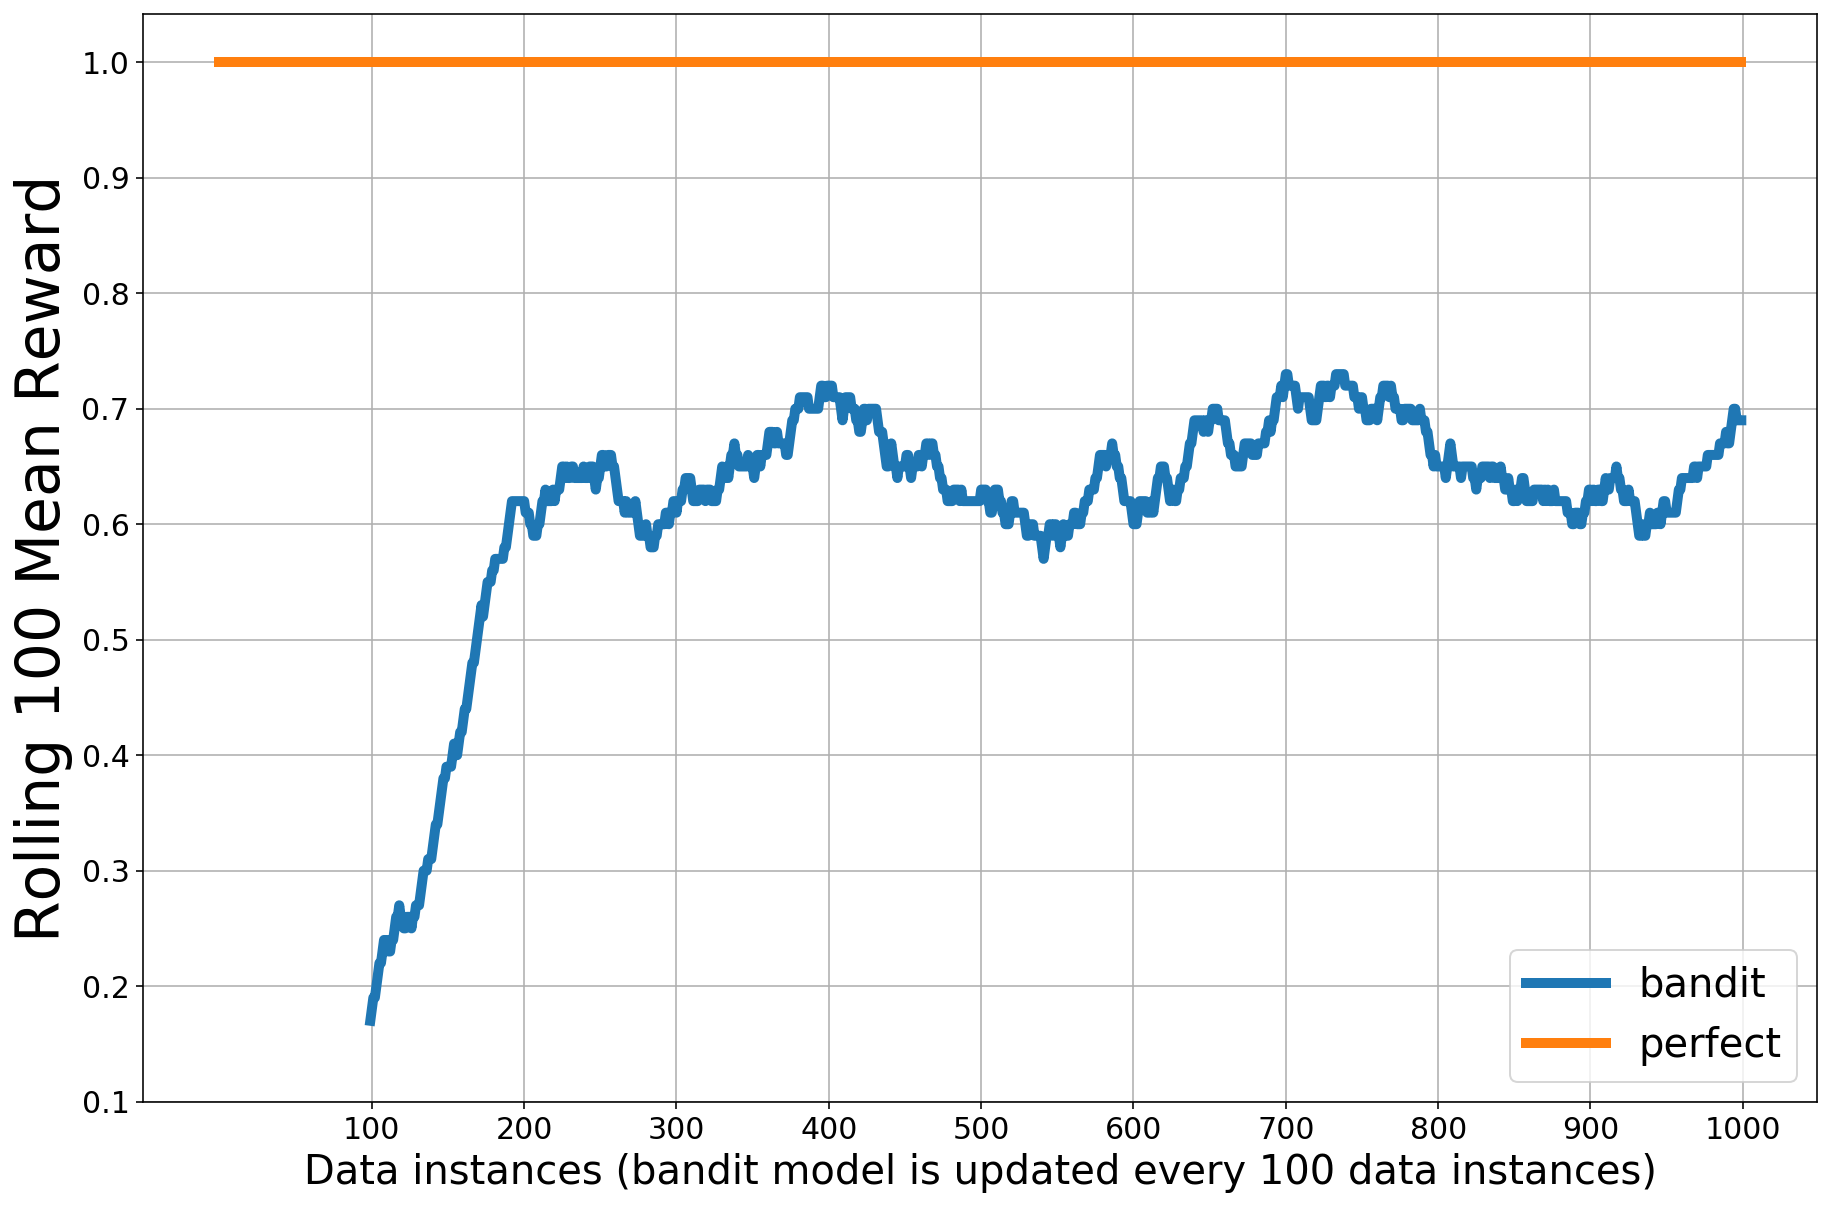

In [53]:
rolling_window = 100

rcParams['figure.figsize'] = 15, 10
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

rewards_df = pd.DataFrame(rewards_list, columns=['bandit']).rolling(rolling_window).mean()
rewards_df['perfect'] = sum(client_app.optimal_rewards) / len(client_app.optimal_rewards)

rewards_df.plot(y=['bandit', 'perfect'], 
                linewidth=lwd)
plt.legend(loc=4, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

plt.xlabel('Data instances (bandit model is updated every %s data instances)' % retrain_batch_size, size=20)
plt.ylabel('Rolling {} Mean Reward'.format(rolling_window), size=30)
plt.grid()
plt.show()

# Check the Invocation Metrics for the BERT Models

In [54]:
from IPython.core.display import display, HTML
    
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [55]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Analyze the Reward Data Across All Models

In [56]:
rewards_df.tail(10)

,bandit,perfect
990,0.67,1.0
991,0.67,1.0
992,0.68,1.0
993,0.69,1.0
994,0.70,1.0
995,0.70,1.0
996,0.69,1.0
997,0.69,1.0
998,0.69,1.0
999,0.69,1.0


In [57]:
rewards_df.bandit.mean()

0.6207325194228631

# Clean Up

We have three DynamoDB tables from the bandits application above (e.g. `experiment_id='bandits-...'`). To better maintain them, we should remove the related records if the experiment has finished. 

Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. 

_The CloudWatch metrics will be removed during this cleanup step._

In [58]:
print('Cleaning up experiment_id {}'.format(bandit_experiment_manager.experiment_id))
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1598138764'...


Cleaning up experiment_id bandits-1598138764


Gracefully stopping... (press Ctrl+C again to force)
